Hi Pratap! Thanks for working on this project for our team.

The CEO and our investors have agreed to put our first risk assessment model utilizing lightGBM into production. Our platform works as follows: when a customer makes a loan application, they fill in some personal information, and with that, we request credit data from four credit agencies. Some of this information is used by the credit risk model to calculate the probability of default. With this probability, we determine if we provide the customer with a loan and the corresponding interest rate.

Our risk team has gathered historical data from previous loan applications and placed it at the root directory of your workspace. The file is called loan_data.csv. This data is a fair representation of the data available when a customer makes a loan application through our platform. Please use this data set to create suitable input features to train and then obtain predictions from a lightGBM. We’d like you to create an end-to-end machine learning pipeline that is able to take in the data entered by the customer and provided by the credit agencies and output a probability of default utilizing a lightGBM.

### Load and Split the Data

The risk analysts have gathered a data set containing customers' financial and personal information and whether they have defaulted in the past. The file is located at the root of your workspace and is called loan_data.csv. The target variable is called "default".

Please load the data and separate it into a training set containing 80% of the customers and a test set containing 20% of the customers.



There are various ways in which you can split the data. For simplicity, please use the train_test_split function from scikit-learn.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("loan_data.csv", low_memory=False)
df.head()

,new_customer,application_date,income_verification,language,date_of_birth,gender,country,loan_amount,county,city,...,credit_score_1,credit_score_2,credit_score_3,credit_score_4,nr_previous_loans,amount_previous_loans,previous_repayments,previous_early_repayments,previous_early_repayments_count,default
0,1,2013-06-10 16:40:39,unverified,estonian,1951-11-25,female,EE,319.5582,HARJU,TALLINN,...,NaN,NaN,NaN,NaN,1,83.0852,0.0000,0.0,0,0
1,0,2013-06-09 15:48:57,unverified,estonian,1964-11-04,female,EE,191.7349,IDA-VIRU,KOHTLA-JARVE,...,NaN,NaN,NaN,NaN,2,255.6467,258.6256,0.0,0,0
2,1,2013-06-04 19:12:29,unverified,estonian,1954-11-12,female,EE,319.5582,PÄRNU,PÄRNU,...,NaN,NaN,NaN,NaN,0,0.0000,0.0000,0.0,0,1
3,1,2013-06-12 12:01:20,unverified,estonian,1990-03-28,female,EE,127.8233,HARJU,PALDISKI,...,NaN,NaN,NaN,NaN,1,134.2144,0.0000,0.0,0,0
4,1,2013-06-09 10:17:13,unverified,estonian,1987-09-29,female,EE,319.5582,TARTU,TARTU,...,NaN,NaN,NaN,NaN,1,146.9966,0.0000,0.0,0,1


In [3]:
seed = 10
 
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("default", axis=1),
    df["default"],
    test_size=0.20,
    random_state=seed,
)

In [4]:
X_train.shape, X_test.shape

((56530, 38), (14133, 38))

In [5]:
y_train.mean(), y_test.mean()

(0.6570493543251371, 0.6432463029788439)

### Evaluate and Impute Numerical Variables

Some of the information we have about our customers comes in the form of numerical variables. For example, the requested loan amount and the income are both numerical and continuous variables. But there are also discrete features, like the number of dependents.

Please have a look at the numerical variable distributions, identify if there are numerical variables with missing data, and in that case, please impute them.

In [6]:
import matplotlib.pyplot as plt

In [7]:
# Find and display the name of the numerical variables
var_num = list(X_train.select_dtypes(include="number").columns)
var_num

['new_customer',
 'loan_amount',
 'nr_dependants',
 'income_from_employer',
 'income_from_pension',
 'income_from_family_allowance',
 'income_from_social_welfare',
 'income_from_leave_pay',
 'income_from_child_support',
 'income_other',
 'nr_debt_items',
 'total_debt',
 'credit_score_4',
 'nr_previous_loans',
 'amount_previous_loans',
 'previous_repayments',
 'previous_early_repayments',
 'previous_early_repayments_count']

In [8]:
# Find and display the name of the discrete variables
var_discrete = [var for var in var_num if X_train[var].nunique() < 20]
var_discrete

['new_customer',
 'nr_dependants',
 'credit_score_4',
 'previous_early_repayments_count']

In [9]:
# Examine the values of the discrete variables
for var in var_discrete:
    print(var)
    print(X_train[var].value_counts(normalize=True))
    print()

new_customer
1    0.559066
0    0.440934
Name: new_customer, dtype: float64

nr_dependants
0.0     0.561921
1.0     0.235011
2.0     0.140656
3.0     0.045282
4.0     0.012356
5.0     0.003370
6.0     0.000702
7.0     0.000456
8.0     0.000035
15.0    0.000035
20.0    0.000035
18.0    0.000035
11.0    0.000035
12.0    0.000035
13.0    0.000035
Name: nr_dependants, dtype: float64

credit_score_4
1000.0    0.778759
800.0     0.077712
900.0     0.071201
600.0     0.036519
700.0     0.035488
500.0     0.000322
Name: credit_score_4, dtype: float64

previous_early_repayments_count
0    0.929754
1    0.054467
2    0.010366
3    0.003449
4    0.001079
5    0.000283
7    0.000265
6    0.000195
8    0.000124
9    0.000018
Name: previous_early_repayments_count, dtype: float64



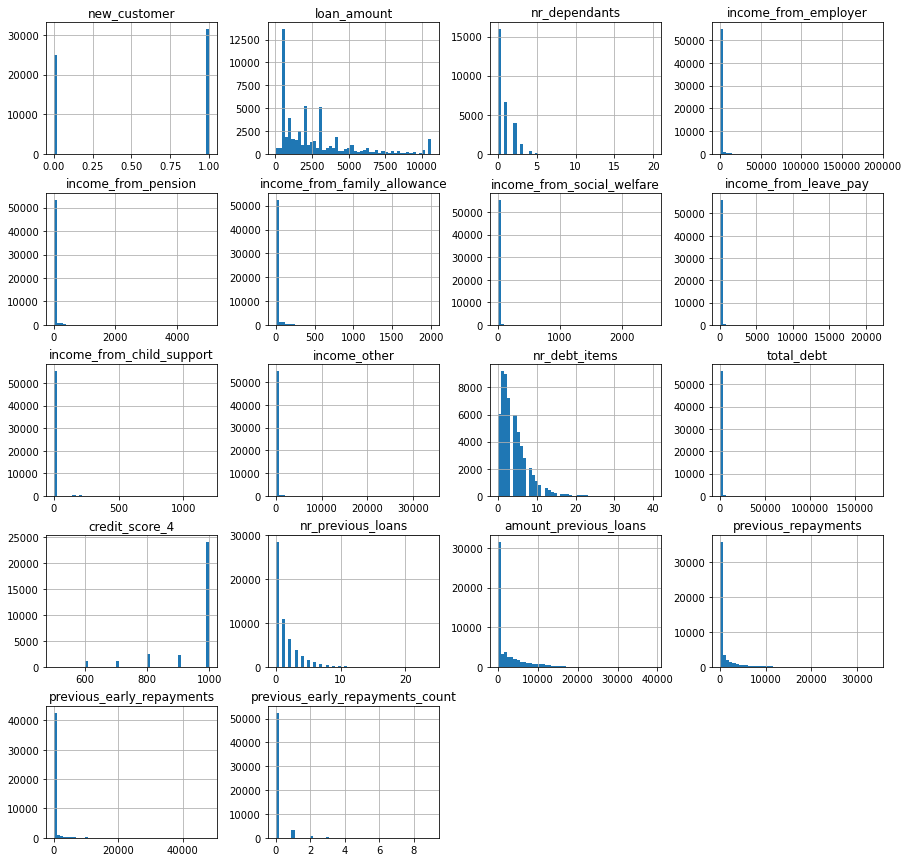

In [10]:
# Examine the distribution of all numerical variables
X_train[var_num].hist(bins=50, figsize=(15,15))
plt.show()

In [11]:
# Identify numerical variables with missing data
var_num_na = [var for var in var_num if X_train[var].isnull().sum() > 0]
var_num_na

['nr_dependants',
 'credit_score_4',
 'previous_repayments',
 'previous_early_repayments']

In [12]:
# Find maximum and minimum values of the variables with missing data
X_train[var_num_na].describe()

,nr_dependants,credit_score_4,previous_repayments,previous_early_repayments
count,28488.000000,31025.000000,48257.000000,45528.000000
mean,0.729254,951.922643,980.815380,260.953051
std,1.026533,103.086680,2327.506222,1399.392338
min,0.000000,500.000000,0.000000,0.000000
25%,0.000000,1000.000000,0.000000,0.000000
50%,0.000000,1000.000000,0.000000,0.000000
75%,1.000000,1000.000000,735.380000,0.000000
max,20.000000,1000.000000,34077.420000,48100.000000


In [13]:
# Create an imputation dictionary with the variables to impute as keys and -1 as value
imputation_num_dict = {var: -1 for var in var_num_na}
imputation_num_dict

{'nr_dependants': -1,
 'credit_score_4': -1,
 'previous_repayments': -1,
 'previous_early_repayments': -1}

In [14]:
# Impute numerical variables from step 6 with the dictionary from previous step
X_train.fillna(value = imputation_num_dict, inplace=True)
X_test.fillna(value = imputation_num_dict, inplace=True)

In [15]:
# Corroborate that there is no missing data left in these variables
X_test[var_num_na].isnull().sum()

nr_dependants                0
credit_score_4               0
previous_repayments          0
previous_early_repayments    0
dtype: int64

### Create new income and debt based variables

Historically, variables that capture the relationship between the customer's income and existing debt have been very useful to assess the customer's probability of defaulting. These variables are:

The customer's total income, which is the sum of all income sources

The debt-to-income ratio, which measures the proportion of income used to pay off existing debt

The discretionary income, which is the money remaining after paying off the monthly debt.

The CEO and our investors will probably want to see that the model uses these variables as input.

Please go ahead and create those variables from the existing data. The variable total_debt which you will find in the data set, represents the customer's monthly debt. In the data set, you will also find many income-related variables representing the different sources of monthly income for each customer. Keep in mind that our platform does not require customers to enter their income. As a result, you may come across customers whose income is zero because they did not disclose it.

In [16]:
# Find the variables representing the different sources of monthly income
var_income = [
    'income_from_employer',
    'income_from_pension',
    'income_from_family_allowance',
    'income_from_social_welfare',
    'income_from_leave_pay',
    'income_from_child_support',
    'income_other',
]

In [17]:
# Create the total income variable by adding up the variables from previous step
X_train['total_income'] = X_train[var_income].sum(axis=1)
X_test['total_income'] = X_test[var_income].sum(axis=1)

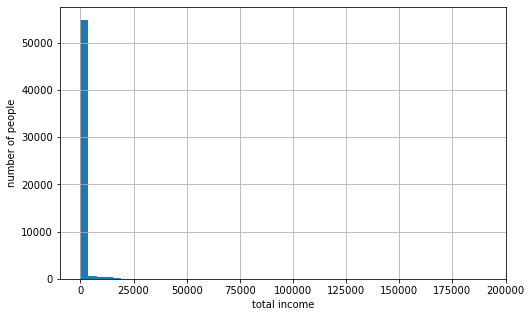

In [18]:
# Display the histogram distribution of the new variable total income
X_train['total_income'].hist(bins=50, figsize=(8,5))
plt.ylabel("number of people")
plt.xlabel("total income")
plt.show()

In [19]:
# Create the variable debt to income ratio and then display the first 5 rows of the input and resulting variables

X_train["dti"] = X_train["total_debt"].div(X_train["total_income"])
X_test["dti"] = X_test["total_debt"].div(X_test["total_income"])
 
X_train[["dti", "total_debt", "total_income"]].head()

,dti,total_debt,total_income
11155,0.822736,854.0,1038.0
50730,0.428182,471.0,1100.0
35924,NaN,0.0,0.0
69230,0.299476,286.0,955.0
35679,inf,245.4,0.0


In [20]:
# Replace the NAN and infinite values introduced by the division in step 4 by the number 0

from numpy import nan, inf
 
X_train["dti"].replace([inf, nan], 0, inplace=True)
X_test["dti"].replace([inf, nan], 0, inplace=True)

In [21]:
# Create the variable cash representing the remaining monthly income after paying the monthly debt

X_train["cash"] = X_train["total_income"].sub(X_train["total_debt"])
X_test["cash"] = X_test["total_income"].sub(X_test["total_debt"])
 
X_train[["cash", "total_debt", "total_income"]].head()

,cash,total_debt,total_income
11155,184.0,854.0,1038.0
50730,629.0,471.0,1100.0
35924,0.0,0.0,0.0
69230,669.0,286.0,955.0
35679,-245.4,245.4,0.0


### Create features from datetime variables

When the customer makes a loan application, the date and time of the application are automatically recorded. We also require customers to enter their date of birth so we can use that to retrieve their financial information from the credit agencies.

Our company only provides loans to customers who are at least 18 years old. Younger customers or customers who wrongly enter their date of birth are automatically declined, and their data is not passed to our credit risk model. If you find such customers in the data set, please remove them.

Using the date of application and the date of birth, please return the age of the customer at the time of application. Age could be a good indicator of credit worthiness. Next, please go ahead and create multiple features to represent the date and time of the application, like month, day of the week, etc.

In [22]:
# Find the variables representing the date of birth an date and time of application and display their first 5 values

vars_temp = ["application_date", "date_of_birth"]
 
X_train[vars_temp].head()

,application_date,date_of_birth
11155,2020-03-25 02:42:53,1973-03-28
50730,2017-12-23 12:49:32,1974-02-19
35924,2021-10-14 13:26:08,1975-01-17
69230,2018-11-09 09:37:29,1980-05-28
35679,2021-10-07 10:48:05,1980-04-20


In [23]:
X_train[vars_temp].isnull().sum()

application_date    0
date_of_birth       0
dtype: int64

In [24]:
# Create a variable to capture the age of the customer at the time of loan application

X_train["age"] = ((pd.to_datetime(X_train["application_date"]) -
                  pd.to_datetime(X_train["date_of_birth"])).dt.days/365).astype(int)
 
X_test["age"] = ((pd.to_datetime(X_test["application_date"]) -
                  pd.to_datetime(X_test["date_of_birth"])).dt.days/365).astype(int)

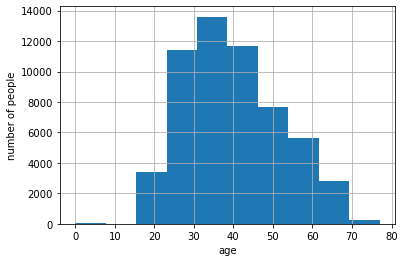

In [25]:
# Create a histogram of the variable age, and see if there are customers younger than 18:

X_train["age"].hist()
plt.xlabel("age")
plt.ylabel("number of people")
plt.show()

In [26]:
# Remove people younger than 18 from the data sets and target variables

X_train = X_train[X_train["age"] >= 18]
X_test = X_test[X_test["age"] >= 18]
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

In [27]:
# Next, from the variable indicating date and time of application, create the features hour, 
# day of the week, day of the month and month

# Create features in train set
X_train["application_date"] = pd.to_datetime(X_train["application_date"])
X_train["dow"] = X_train["application_date"].dt.day_of_week
X_train["dom"] = X_train["application_date"].dt.day
X_train["month"] = X_train["application_date"].dt.month
X_train["hour"] = X_train["application_date"].dt.hour
# Create features in test set
X_test["application_date"] = pd.to_datetime(X_test["application_date"])
X_test["dow"] = X_test["application_date"].dt.day_of_week
X_test["dom"] = X_test["application_date"].dt.day
X_test["month"] = X_test["application_date"].dt.month
X_test["hour"] = X_test["application_date"].dt.hour
# Display new features
X_train[["application_date", "dow", "dom", "month", "hour"]].head()

,application_date,dow,dom,month,hour
11155,2020-03-25 02:42:53,2,25,3,2
50730,2017-12-23 12:49:32,5,23,12,12
35924,2021-10-14 13:26:08,3,14,10,13
69230,2018-11-09 09:37:29,4,9,11,9
35679,2021-10-07 10:48:05,3,7,10,10


In [28]:
# Drop the original datetime variables from the data sets

X_train.drop(["application_date", "date_of_birth"], axis=1, inplace=True)
X_test.drop(["application_date", "date_of_birth"], axis=1, inplace=True)

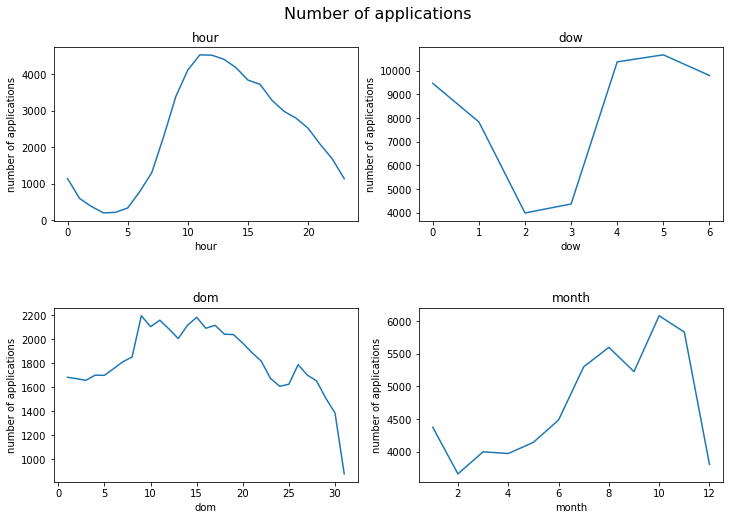

In [29]:
# Plot the number of applications per value of the features from previous step

# Define subplot grid
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Number of applications", fontsize=16, y=0.95)
 
new_features = ["hour", "dow", "dom", "month"]
 
# loop through variables and axes
for var, ax in zip(new_features, axs.ravel()):
    
    # Plot the variable
    X_train.groupby(var)[var].count().plot(ax=ax)
 
    # Plot formatting
    ax.set_title(var)
    ax.set_ylabel("number of applications")

### Evaluate categorical variables cardinality

Much of the information we have about our customers comes in the form of strings. For example, gender, marital status, employment and others.

We accept applications from all over Europe. Therefore, some values, like job position, are entered in different languages, and you will see that they have a multitude of unique values. We'd rather not use such variables in our credit risk model because we anticipate future values that are not present in our current data sets, and therefore, the model will not be able to process them.

Please go ahead and find highly cardinal categorical variables and remove them from the data sets.

In [30]:
# Find the name of the categorical variables, that is, those cast as object:

vars_cat = [x for x in X_train.select_dtypes(include="O").columns if x not in vars_temp]
 
vars_cat

['income_verification',
 'language',
 'gender',
 'country',
 'county',
 'city',
 'use_of_loan',
 'education',
 'marital_status',
 'employment_status',
 'employment_duration',
 'employment_position',
 'work_experience',
 'occupation',
 'home_ownership',
 'credit_score_1',
 'credit_score_2',
 'credit_score_3']

In [31]:
X_train[vars_cat].head(5)

,income_verification,language,gender,country,county,city,use_of_loan,education,marital_status,employment_status,employment_duration,employment_position,work_experience,occupation,home_ownership,credit_score_1,credit_score_2,credit_score_3
11155,unverified,spanish,female,ES,CATALUNYA,LLEIDA,loan_consolidation,secondary,divorced,retiree,UpTo5Years,Worker,15To25Years,other,tenant_furnished,M1,B,NaN
50730,income_and_expenses_verified,spanish,female,ES,MADRID,MADRID,other,higher,single,fully,UpTo5Years,telefonioperaator,15To25Years,telecom,tenant_furnished,M1,B,NaN
35924,income_and_expenses_verified,russian,male,EE,Harju maakond,Tallinn,unknown,higher,NaN,NaN,UpTo5Years,NaN,NaN,NaN,owner,M,NaN,NaN
69230,income_and_expenses_verified,estonian,male,EE,HARJU,TALLINN,vehicle,secondary,single,fully,UpTo2Years,Executive,10To15Years,construction,tenant_furnished,NaN,NaN,NaN
35679,unverified,russian,male,EE,Harju maakond,Tallinn,unknown,secondary,NaN,NaN,MoreThan5Years,NaN,NaN,NaN,owner,M,NaN,NaN


<AxesSubplot:>

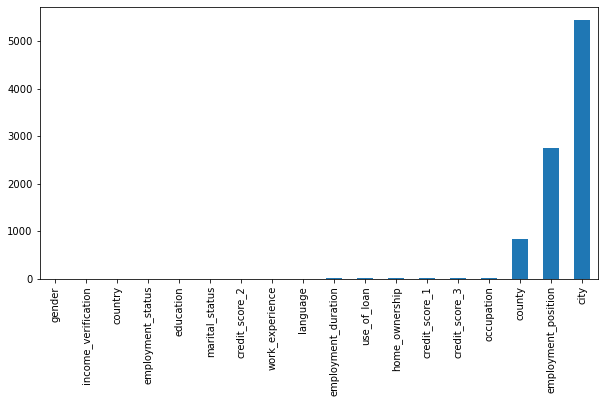

In [32]:
# Determine the number of unique categories per variable and plot them in a bar plot:

X_train[vars_cat].nunique().sort_values(ascending=True).plot.bar(figsize=(10, 5))

In [33]:
# Find the 3 variables with highest cardinality, and plot their first 20 unique values:

highly_cardinal_vars = ["employment_position", "city", "county"]
 
for var in highly_cardinal_vars:
    print(var)
    print(X_train[var].unique()[0:20])
    print()

employment_position
['Worker' 'telefonioperaator' nan 'Executive' 'MiddleManager'
 'SpecialistOfficeWorker' 'Camarero'
 'müügisekretär  ( hetkel kodune lapsega) ' 'Jurist' 'Autopesija' 'Owner'
 'Insener' 'Cámara y Periodista ' 'operaator-klienditeenindaja' 'liimia'
 'Comercial' 'operaator' 'Haljastustööline ' 'Tegevjuht' 'Linnu talitaja']

city
['LLEIDA' 'MADRID' 'Tallinn' 'TALLINN' nan 'Tahkuranna vald' 'Põlva vald'
 'MÁLAGA' 'PALDISKI' 'PORI' 'KOUVOLA' 'VALENCIA' 'VÕRU' 'Tartu linn'
 'LUIGE' 'Viljandi linn' 'Kanepi vald' 'KIURUVESI' 'ECIJA' 'MURASTE KÜLA']

county
['CATALUNYA' 'MADRID' 'Harju maakond' 'HARJU' nan 'Pärnu maakond'
 'Põlva maakond' 'ANDALUCÍA' 'VALENCIA' 'VÕRUMAA' 'Tartu maakond'
 'Viljandi maakond' 'SEVILLA' 'JÄRVAMAA' 'PIRKANMAA' 'COMUNIDAD DE MADRID'
 'PÄRNU' 'PÄRNU MAAKOND' 'ŽILINSKÝ KRAJ' 'Ida-Viru maakond']



In [34]:
# Remove the variables from previous step from the data sets:

X_train.drop(highly_cardinal_vars, axis=1, inplace=True)
X_test.drop(highly_cardinal_vars, axis=1, inplace=True)

### Impute Categorical variables

In [35]:
# Remove the highly cardinal variables from the list of categorical variables

vars_cat = [var for var in vars_cat if var not in highly_cardinal_vars]

In [36]:
# Find the name of categorical variables with missing data

var_cat_na = [var for var in vars_cat if X_train[var].isnull().sum() > 0]
 
var_cat_na

['gender',
 'education',
 'marital_status',
 'employment_status',
 'employment_duration',
 'work_experience',
 'occupation',
 'home_ownership',
 'credit_score_1',
 'credit_score_2',
 'credit_score_3']

In [37]:
# Create a dictionary with the variables to impute as keys and the string "missing" as value

imputation_cat_dict = {var: "missing" for var in var_cat_na}
imputation_cat_dict

{'gender': 'missing',
 'education': 'missing',
 'marital_status': 'missing',
 'employment_status': 'missing',
 'employment_duration': 'missing',
 'work_experience': 'missing',
 'occupation': 'missing',
 'home_ownership': 'missing',
 'credit_score_1': 'missing',
 'credit_score_2': 'missing',
 'credit_score_3': 'missing'}

In [38]:
# Impute missing data in categorical variables

X_train.fillna(value=imputation_cat_dict, inplace=True)
X_test.fillna(value=imputation_cat_dict, inplace=True)

In [39]:
X_test[var_cat_na].isnull().sum()

gender                 0
education              0
marital_status         0
employment_status      0
employment_duration    0
work_experience        0
occupation             0
home_ownership         0
credit_score_1         0
credit_score_2         0
credit_score_3         0
dtype: int64

### Group Infrequent Categories

Some of the categorical variables accept values that are very rare. For example, our main customer base speaks Estonian, Finnish, Spanish, and Russian. But since we do accept applications from all over Europe, some other languages can also be taken as input. As a result, only a small percentage of customers speak languages other than those listed above. And in addition, future customers may speak a language that we currently do not have in our data set. Thus, we would like to group infrequent values into one single category, called "rare."

Please group categories that are present in less than 5% of the observations into a single value for the following variables:

language

use_of_loan

occupation

home_ownership

credit_score_1

credit_score_2

credit_score_3

In [40]:
# Create a list with the names of the categorical variables that need category grouping

vars_group = [
    'language',
    'use_of_loan',
    'occupation',
    'home_ownership',
    'credit_score_1',
    'credit_score_2',
    'credit_score_3',
]

In [41]:
# Create a dictionary containing the variables from previous step as keys and a list 
# with the categories present in more than 5% of the observations as values

frequent_cat_dict = {}
 
for var in vars_group:
    categories = X_train[var].value_counts(normalize=True)
    categories = list(categories[categories > 0.05].index)
    frequent_cat_dict[var] = categories

In [42]:
frequent_cat_dict

{'language': ['estonian', 'finnish', 'spanish', 'russian'],
 'use_of_loan': ['unknown', 'other', 'home_improvement', 'loan_consolidation'],
 'occupation': ['missing', 'other', 'retail'],
 'home_ownership': ['owner',
  'tenant_furnished',
  'living_with_parents',
  'mortgage',
  'tenant_unfurnished'],
 'credit_score_1': ['missing', 'M', 'M1'],
 'credit_score_2': ['missing', 'B'],
 'credit_score_3': ['missing', 'RL2']}

In [44]:
# Rename categories that are not present in the lists from previous step with the string "Rare"
import numpy as np
for var in vars_group:
    X_train[var] = np.where(X_train[var].isin(
        frequent_cat_dict[var]), X_train[var], "Rare")
 
    X_test[var] = np.where(X_test[var].isin(
        frequent_cat_dict[var]), X_test[var], "Rare")

In [45]:
X_test["language"].value_counts(normalize=True)

estonian    0.541959
finnish     0.184973
spanish     0.166277
russian     0.093336
Rare        0.013455
Name: language, dtype: float64

### Encode categorical variables

The Python implementation of lightGBM does not support strings as values. So you need to replace the category values of categorical variables with numbers.



In [47]:
# Import joblib and the ordinal encoder from scikit-learn

import joblib
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
enc.fit(X_train[vars_cat])

OrdinalEncoder()

In [48]:
# Encode categorical variables in train and test sets

X_train[vars_cat] = enc.transform(X_train[vars_cat])
X_test[vars_cat] = enc.transform(X_test[vars_cat])

In [49]:
X_train[vars_cat].head(5)

,income_verification,language,gender,country,use_of_loan,education,marital_status,employment_status,employment_duration,work_experience,occupation,home_ownership,credit_score_1,credit_score_2,credit_score_3
11155,1.0,4.0,0.0,1.0,2.0,4.0,1.0,4.0,8.0,1.0,2.0,4.0,1.0,0.0,2.0
50730,0.0,4.0,0.0,1.0,3.0,1.0,4.0,1.0,8.0,1.0,0.0,4.0,1.0,0.0,2.0
35924,0.0,3.0,1.0,0.0,4.0,1.0,3.0,2.0,8.0,6.0,1.0,3.0,0.0,2.0,2.0
69230,0.0,1.0,1.0,0.0,0.0,4.0,4.0,1.0,5.0,0.0,0.0,4.0,3.0,2.0,2.0
35679,1.0,3.0,1.0,0.0,4.0,4.0,3.0,2.0,0.0,6.0,1.0,3.0,0.0,2.0,2.0


In [50]:
# Save encoder for later use
joblib.dump(enc, "encoder.pkl")

['encoder.pkl']

### Train and Evaluate a lightGBM

Now that you have a fully preprocessed dataset containing transformed and new features, please go ahead and train and evaluate a lightGBM model.

Using the Python API for lightGBM, set up and train a lightGBM model. To speed up training, use callbacks to stop the training if the performance does not improve after 3 iterations. Collect the training results in a dictionary so you can determine if the learning converged.

To evaluate the model, please use the ROC-AUC and also create a full classification report containing the precision, recall, f1-score, and accuracy values.

In [52]:
! pip install lightgbm

In [54]:
# Import the lightGBM package and the metrics to evaluate the model

import lightgbm as lgb
from sklearn.metrics import roc_auc_score, classification_report

OSError: dlopen(/Users/prataprc94/opt/anaconda3/lib/python3.8/site-packages/lightgbm/lib_lightgbm.so, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: /Users/prataprc94/opt/anaconda3/lib/python3.8/site-packages/lightgbm/lib_lightgbm.so
  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file)

In [ ]:
# Set up the lightGM model

gbm = lgb.LGBMClassifier(
    num_iterations=1000,
    random_state=seed,
)

In [ ]:
# Create a dictionary to collect the training results

evals_result = {}

In [ ]:
# Train the model

gbm.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    categorical_feature=vars_cat,
    callbacks=[
        lgb.early_stopping(3),
        lgb.record_evaluation(evals_result),
    ],
)

In [ ]:
# Plot the values of the binary log loss collected in the dictionary from previous step

ax = lgb.plot_metric(evals_result, metric='binary_logloss')
 
plt.show()

> the values of the binary log loss obtained after each iteration of training the lightGBM. The values reach a plateau at higher iterations, suggesting that the learning converged at a minimum of the optimization function:

In [55]:
# Calculate the probability of default in train and test sets

pred_train = gbm.predict_proba(X_train)[:, 1]
pred_test = gbm.predict_proba(X_test)[:, 1]

NameError: name 'gbm' is not defined

In [ ]:
# Calculate the ROC-AUC

roc_train = roc_auc_score(y_train, pred_train)
roc_test = roc_auc_score(y_test, pred_test)

In [ ]:
# Print out the ROC-AUC values

print(f"Train set roc-auc: {roc_train}")
print(f"Eval set roc-auc: {roc_test}")

In [ ]:
# Predict if the customers will default in train and test sets

pred_train = gbm.predict(X_train)
pred_test = gbm.predict(X_test)

In [ ]:
# Calculate the full classification report

cr_train = classification_report(y_train, pred_train)
cr_test = classification_report(y_test, pred_test)

In [ ]:
# Print out the classification reports

print(f"Train set:\n {cr_train}")
print(f"Eval set:\n {cr_test}")

In [ ]:
# Save model for later

joblib.dump(gbm, "lightGBM.pkl")

### Evaluate feature importance

We'd like to understand which features are useful to predict credit risk. To get a broad overview of feature importance, we'd like to evaluate features with more than one method. To begin, please determine the feature importance returned by the lightGBM. Then evaluate the feature's importance by permutation. This method consists of randomly shuffling the values of each feature, one at a time, then obtaining predictions utilizing the shuffled feature and determining the drop in performance, if any, caused by the permutation.

Finally, train single-feature classifiers and determine if each feature, individually, returns a model that outputs predictions that are better than returning a random guess. Use simple decision trees as classifiers, and the ROC-AUC as a performance metric.

In [ ]:
# Plot the feature importance according to the lightGBM

ax = lgb.plot_importance(gbm, figsize=(15, 10))
plt.show()

In [ ]:
# Import the permutation_importance from scikit-learn

from sklearn.inspection import permutation_importance

In [ ]:
# Determine the drop in performance generated by randomly shuffling the values of each feature

result = permutation_importance(
    gbm,
    X_test,
    y_test,
    scoring="roc_auc",
    n_repeats=3,
    random_state=seed,
)

In [ ]:
# Plot the drop in performance induced by permutation of each feature in descending order

result = pd.Series(result.importances_mean, index=X_train.columns)
result.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.ylabel("permutation importance")

In [ ]:
# Identify all features that caused any drop in performance when shuffled

feature_subset_1 = list((result>0).index)
print(len(feature_subset_1))
feature_subset_1

> The previous code block returns the name of the 41 input features. This means that shuffling every single feature in the test set, caused a decrease in the observed performance. Hence, all features are important

In [ ]:
# Import the decision tree classifier and the cross validation function from scikit-learn

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate

In [ ]:
# Set up a decision tree classifier

clf = DecisionTreeClassifier(random_state=seed)

# Create a dictionary to store the performance of each model trained on a single feature

result = {}

In [ ]:
# Create a classifier that takes every single feature as input, 
# and evaluate its performance using the ROC-AUC as metric with cross-validation

# Loop over every feature
for var in X_train.columns:
    
    # Train and evaluate a classifier with crossvalidation
    tmp = cross_validate(
        clf,
        X_train[var].to_frame(),
        y_train,
        cv=3,
        scoring="roc_auc",
    )
    
    # Store the result
    result[var] = tmp["test_score"].mean()

In [ ]:
# Plot the ROC-AUC returned by every single feature classifier

result = pd.Series(result, index=X_train.columns)
result.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.ylabel("permutation importance")

In [ ]:
# Determine if there are features that returned random classifiers

feature_subset_2 = list((result>0.5).index)
print(len(feature_subset_2))

> The previous code block returns the name of the 41 input features:

> Every feature returned a decision tree whose ROC-AUC was greater than 0.5. ROC-AUC values of 0.5 represent random guesses. Hence, using single feature classifiers we corroborate that all features are important to assess credit risk.

### create an end-to-end feature engineering pipeline

put all your feature transformation and creation steps in a clean pipeline that we could use to score any data set or data coming through our platform whenever a customer creates a loan application.

The basic idea of the pipeline is that it takes the raw data and returns a fully preprocessed data set with input features ready to be used by the lightGBM to make the predictions.

Please start on a clean notebook so that we can have a clean copy of the entire pipeline to smooth deployment later on. ---> ML_Pipeline_for_Credit_Risk_Analysis